In [2]:
from rdflib import Graph, URIRef, Literal, Namespace
g = Graph()

#ALIGNMENT_RDF_FILE_PATH = "../XP/L3.ttl"
#COURSES_RDF_FILE_PATH = "/Users/molli-p/NUCS-KG/XP/licence2025/L3.ttl"

ALIGNMENT_RDF_FILE_PATH = "./XP/bok-groq.ttl"
COURSES_RDF_FILE_PATH = "./data/courses_splitted.ttl"


#ALIGNMENT_RDF_FILE_PATH = "./XP/bokc.ttl"
#COURSES_RDF_FILE_PATH = "./data/courses.ttl"

g.parse(ALIGNMENT_RDF_FILE_PATH, format="turtle")
g.parse(COURSES_RDF_FILE_PATH, format="turtle")

print(f"Graph loaded : {g.__len__()} triples")

Graph loaded : 8475 triples


In [3]:
distinct_ue= """
PREFIX ns1: <http://example.org/course/>

SELECT (COUNT(DISTINCT ?s) AS ?nb_UE)
WHERE {
  ?s ns1:content ?content .
}
"""

empty_content= """
PREFIX ns1: <http://example.org/course/>

SELECT (COUNT(?s) AS ?nb_sujets_courts)
WHERE {
  ?s ns1:content ?content .
  FILTER(STRLEN(STR(?content)) < 10)
}
"""

qres = g.query(distinct_ue)
for row in qres:
    print(f"Number of distinct UE: {row.nb_UE}")

qres = g.query(empty_content)
for row in qres:
    print(f"Number of short content: {row.nb_sujets_courts}")

Number of distinct UE: 94
Number of short content: 42


In [4]:
aligned_ue= """
prefix ns1: <http://provo.org/> 
prefix ns2: <http://example.org/course/> 
prefix ns3: <http://align.org/> 
prefix xsd: <http://www.w3.org/2001/XMLSchema#> 

SELECT DISTINCT ?ue ?parcours ?ku ?ka
WHERE {
  ?ue ns2:parcours  ?parcours .
  ?ue ns3:to [
    ns2:answer "1" ;
    ns2:ku ?ku ;
    ns2:ka ?ka ;
    ns1:wasGeneratedBy [ ns1:used "llama3-8b-8192" ]
  ] .
} limit 10
"""
qres = g.query(aligned_ue)
for row in qres:
    print(f"UE: {row.ue}, ?parcours {row.parcours}, KU: {row.ku}, KA: {row.ka}")

UE: http://example.org/course/X1CI010, ?parcours CMI, KU: AR-Representation_Machine-Level_Data_Representation, KA: Architecture_and_Organization_AR
UE: http://example.org/course/X1CI010, ?parcours CMI, KU: SPD-Common_Aspects, KA: Specialized_Platform_Development_SPD
UE: http://example.org/course/X1I1010, ?parcours ALMA, KU: SF-Basic_Concepts, KA: System_Fundamentals_SF
UE: http://example.org/course/X1I1010, ?parcours ALMA, KU: FPL-Functional_Functional_Programming, KA: Foundations_of_Programming_Languages_FPL
UE: http://example.org/course/X1I1010, ?parcours ALMA, KU: MSF-Linear_Linear_Algebra, KA: Mathematical_and_Statistical_Foundations_MSF
UE: http://example.org/course/X1I1020, ?parcours ALMA, KU: SE-Software_Development, KA: Software_Engineering_SE
UE: http://example.org/course/X1I1020, ?parcours ALMA, KU: SDF-Software_Development_Practices, KA: Software_Development_Fundamentals_SDF
UE: http://example.org/course/X1I1020, ?parcours ALMA, KU: FPL-Methodologies_Formal_Development_Metho

In [5]:
radar_llama3_8b= """
prefix ns1: <http://provo.org/> 
prefix ns2: <http://example.org/course/> 
prefix ns3: <http://align.org/> 
prefix xsd: <http://www.w3.org/2001/XMLSchema#> 

SELECT DISTINCT  ?parcours ?ka (count(distinct ?ku) as ?nb_ku)
WHERE {
  ?ue ns2:parcours  ?parcours .
  ?ue ns3:to [
    ns2:answer "1" ;
    ns2:ku ?ku ;
    ns2:ka ?ka ;
    ns1:wasGeneratedBy [ ns1:used "llama3-8b-8192" ]
  ] .
} group by ?parcours ?ka
"""
radar_data = g.query(radar_llama3_8b)
for row in radar_data:
    print(f"Parcours: {row.parcours}, KA: {row.ka}, KU: {row.nb_ku}")

Parcours: CMI, KA: Architecture_and_Organization_AR, KU: 2
Parcours: CMI, KA: Specialized_Platform_Development_SPD, KU: 3
Parcours: ALMA, KA: System_Fundamentals_SF, KU: 1
Parcours: ALMA, KA: Foundations_of_Programming_Languages_FPL, KU: 8
Parcours: ALMA, KA: Mathematical_and_Statistical_Foundations_MSF, KU: 4
Parcours: ALMA, KA: Software_Engineering_SE, KU: 6
Parcours: ALMA, KA: Software_Development_Fundamentals_SDF, KU: 3
Parcours: ALMA, KA: Date_Management_DM, KU: 6
Parcours: ATAL, KA: Date_Management_DM, KU: 5
Parcours: DS, KA: Date_Management_DM, KU: 5
Parcours: VICO, KA: Date_Management_DM, KU: 4
Parcours: ALMA, KA: Algorithmic_Foundations_AL, KU: 3
Parcours: ATAL, KA: Algorithmic_Foundations_AL, KU: 3
Parcours: DS, KA: Algorithmic_Foundations_AL, KU: 3
Parcours: VICO, KA: Algorithmic_Foundations_AL, KU: 3
Parcours: ALMA, KA: Specialized_Platform_Development_SPD, KU: 4
Parcours: ATAL, KA: Specialized_Platform_Development_SPD, KU: 4
Parcours: DS, KA: Specialized_Platform_Developme

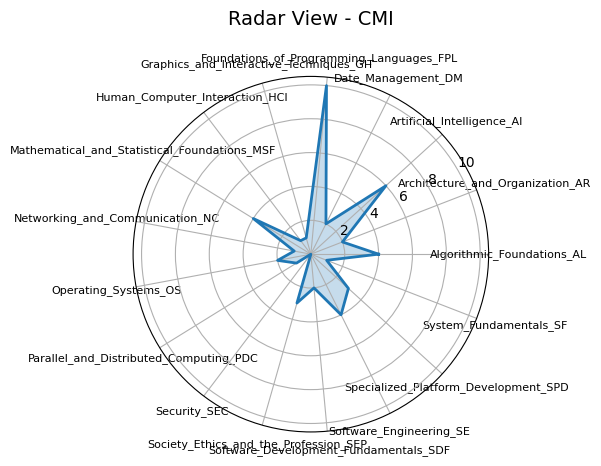

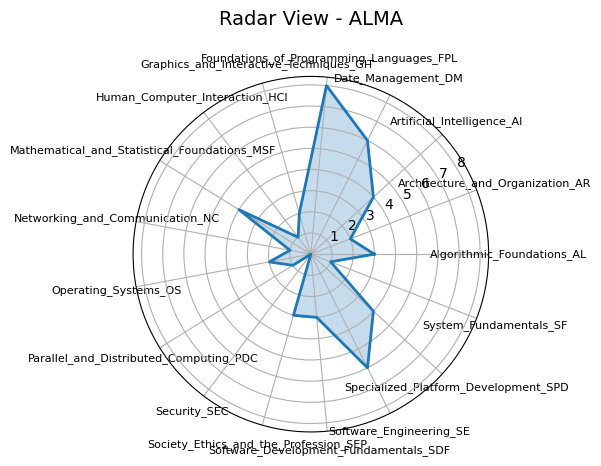

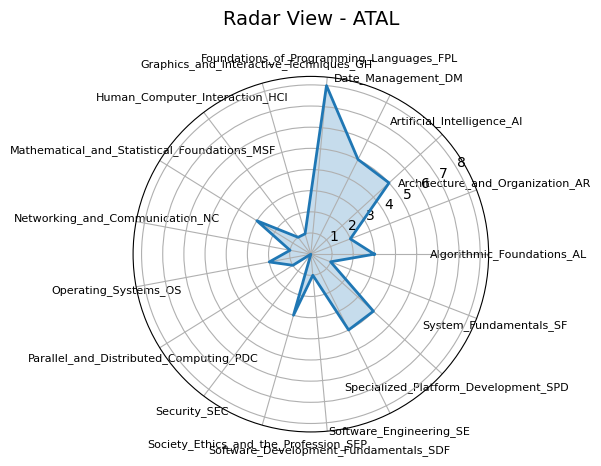

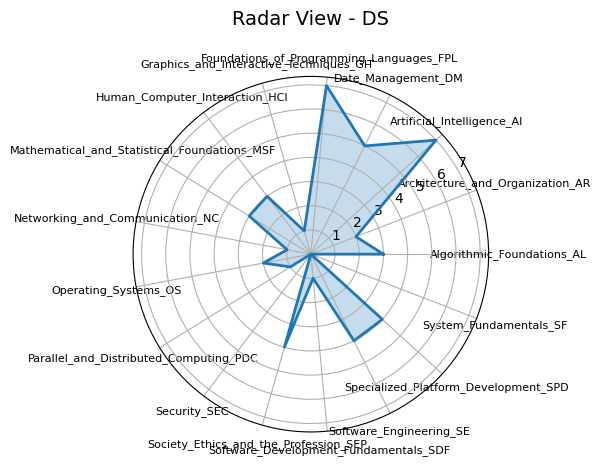

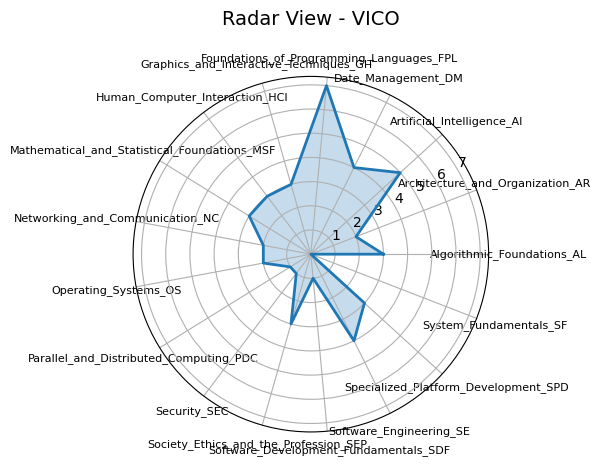

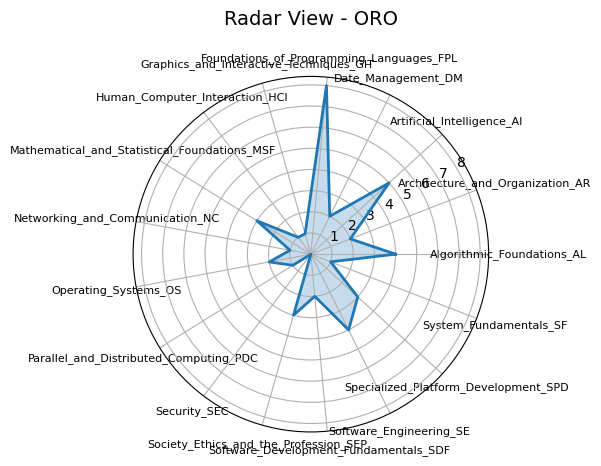

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

# 1. Collecte des résultats de la requête
data = defaultdict(dict)  # {parcours: {ka: nb_ku}}

for row in radar_data:
    parcours = str(row.parcours)
    ka = str(row.ka)
    nb_ku = int(row.nb_ku)
    data[parcours][ka] = nb_ku

# 2. Construction de l'ensemble des axes (toutes les KA rencontrées)
all_kas = sorted({ka for parcours_data in data.values() for ka in parcours_data})

# 3. Plot radar chart par parcours
def radar_factory(num_vars):
    # angles equally spaced around the circle
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # complete the loop
    return angles

angles = radar_factory(len(all_kas))

for parcours, ka_dict in data.items():
    values = [ka_dict.get(ka, 0) for ka in all_kas]
    values += values[:1]  # boucler le graphe

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.plot(angles, values, linewidth=2, label=parcours)
    ax.fill(angles, values, alpha=0.25)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(all_kas, fontsize=8, wrap=True)
    ax.set_title(f"Radar View - {parcours}", size=14, pad=20)
    ax.set_rlabel_position(30)
    ax.grid(True)

    plt.tight_layout()
    plt.show()


In [7]:
minority_report="""
PREFIX ns1: <http://provo.org/> 
PREFIX ns2: <http://example.org/course/> 
PREFIX ns3: <http://align.org/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT DISTINCT ?ue ?ku ?model ?answer ?score
WHERE {
  ?ue ns3:to [
    ns2:ku ?ku ;
    ns2:answer ?answer ;
    ns3:score ?score ;
    ns1:wasGeneratedBy [ ns1:used ?model ]
  ] .
} order by ?ue ?ku ?model
"""
mreport_data = g.query(minority_report)
for row in mreport_data:
    print(f"UE: {row.ue}, KU: {row.ku}, Model: {row.model}, Answer: {row.answer}, Score: {row.score}")


UE: http://example.org/course/X1CI010, KU: AR-Representation_Machine-Level_Data_Representation, Model: deepseek-r1-distill-llama-70b, Answer: 0, Score: 0.6523384
UE: http://example.org/course/X1CI010, KU: AR-Representation_Machine-Level_Data_Representation, Model: llama3-8b-8192, Answer: 1, Score: 0.6523384
UE: http://example.org/course/X1CI010, KU: AR-Representation_Machine-Level_Data_Representation, Model: qwen-qwq-32b, Answer: 0, Score: 0.6523384
UE: http://example.org/course/X1CI010, KU: SE-Formal_Methods, Model: deepseek-r1-distill-llama-70b, Answer: 0, Score: 0.66345507
UE: http://example.org/course/X1CI010, KU: SE-Formal_Methods, Model: llama3-8b-8192, Answer: 0, Score: 0.66345507
UE: http://example.org/course/X1CI010, KU: SE-Formal_Methods, Model: qwen-qwq-32b, Answer: 0, Score: 0.66345507
UE: http://example.org/course/X1CI010, KU: SPD-Common_Aspects, Model: deepseek-r1-distill-llama-70b, Answer: 0, Score: 0.65906644
UE: http://example.org/course/X1CI010, KU: SPD-Common_Aspects

/var/folders/r9/qykcs5sx4pd87v_cyp4hg9kh0000gp/T/ipykernel_41512/3803695391.py:24: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sns.heatmap(pivot_df.replace({'0': 0, '1': 1}), cmap="coolwarm", annot=True, cbar=False)


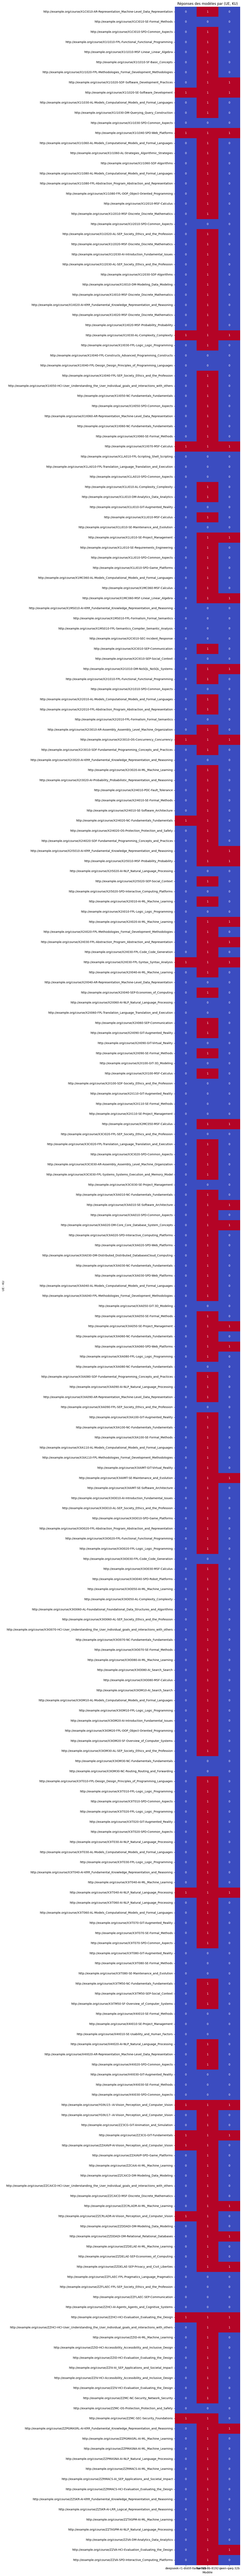

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Récupération des résultats dans une liste
results = []
for row in mreport_data:
    results.append({
        'UE': str(row.ue),
        'KU': str(row.ku),
        'Model': str(row.model),
        'Answer': str(row.answer),
        'Score': float(row.score)
    })

# Création d’un DataFrame
df = pd.DataFrame(results)

# Pivot pour heatmap: lignes = (UE, KU), colonnes = modèles, valeurs = réponse
pivot_df = df.pivot_table(index=['UE', 'KU'], columns='Model', values='Answer', aggfunc='first')

# Affichage sous forme de heatmap catégorielle (0/1)
plt.figure(figsize=(12, max(6, len(pivot_df) * 0.5)))
sns.heatmap(pivot_df.replace({'0': 0, '1': 1}), cmap="coolwarm", annot=True, cbar=False)
plt.title("Réponses des modèles par (UE, KU)")
plt.xlabel("Modèle")
plt.ylabel("UE - KU")
plt.tight_layout()
plt.show()


In [9]:
consensus_align="""
PREFIX ns1: <http://provo.org/> 
PREFIX ns2: <http://example.org/course/> 
PREFIX ns3: <http://align.org/>

SELECT DISTINCT ?ue ?ku
WHERE {
  # Tous les modèles ayant donné un avis ont répondu "1"
  ?ue ns3:to [
    ns2:ku ?ku ;
    ns2:answer "1"
  ] .

  # Il ne doit exister aucun modèle ayant répondu "0" sur cette paire
  FILTER NOT EXISTS {
    ?ue ns3:to [
      ns2:ku ?ku ;
      ns2:answer "0"
    ]
  }
}
"""
qres = g.query(consensus_align)
for row in qres:
    # On affiche les UE et KU qui ont un consensus
    # d'alignement (tous les modèles ont répondu "1" et aucun n'a répondu "0")
    print(f"UE: {row.ue}, KU: {row.ku}")

UE: http://example.org/course/X1I1020, KU: SE-Software_Development
UE: http://example.org/course/X1I1040, KU: SPD-Web_Platforms
UE: http://example.org/course/X1II030, KU: AL-Complexity_Complexity
UE: http://example.org/course/X1II070, KU: MSF-Calculus
UE: http://example.org/course/X2I3010, KU: OS-Concurrency_Concurrency
UE: http://example.org/course/X2II030, KU: FPL-Syntax_Syntax_Analysis
UE: http://example.org/course/X3IT040, KU: AI-NLP_Natural_Language_Processing
UE: http://example.org/course/YG9U15-, KU: AI-Vision_Perception_and_Computer_Vision
UE: http://example.org/course/ZZ3CG, KU: GIT-Fundamentals
UE: http://example.org/course/ZZHCI, KU: HCI-Evaluation_Evaluating_the_Design


In [10]:
qres = g.query(consensus_align)
for row in qres:
    # On affiche les UE et KU qui ont un consensus
    # d'alignement (tous les modèles ont répondu "1" et aucun n'a répondu "0")
    print(f"UE: {row.ue}, KU: {row.ku}")

UE: http://example.org/course/X1I1020, KU: SE-Software_Development
UE: http://example.org/course/X1I1040, KU: SPD-Web_Platforms
UE: http://example.org/course/X1II030, KU: AL-Complexity_Complexity
UE: http://example.org/course/X1II070, KU: MSF-Calculus
UE: http://example.org/course/X2I3010, KU: OS-Concurrency_Concurrency
UE: http://example.org/course/X2II030, KU: FPL-Syntax_Syntax_Analysis
UE: http://example.org/course/X3IT040, KU: AI-NLP_Natural_Language_Processing
UE: http://example.org/course/YG9U15-, KU: AI-Vision_Perception_and_Computer_Vision
UE: http://example.org/course/ZZ3CG, KU: GIT-Fundamentals
UE: http://example.org/course/ZZHCI, KU: HCI-Evaluation_Evaluating_the_Design


In [11]:
verif_report="""
PREFIX provo: <http://provo.org/> 
PREFIX course: <http://example.org/course/> 
PREFIX align: <http://align.org/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT DISTINCT ?ue ?ue_text ?ku ?ku_source (GROUP_CONCAT(CONCAT(?answer,':',?model);separator=",") as ?rep)
WHERE {
  ?ue course:content ?content .
  ?ue rdfs:label ?label .
  ?ue course:objective ?objective .
  BIND(CONCAT("Label: ",STR(?label)," Objectif: ",STR(?objective),
                " Course content: ", STR(?content)," Course name: ",STR(?ue)) AS ?ue_text)
  ?ue align:to [
    course:ku ?ku ;
    align:ku_source ?ku_source ;
    course:answer ?answer ;
    align:score ?score ;
    provo:wasGeneratedBy [ provo:used ?model ]
  ] .
} group by ?ue ?ku 
"""
verif_data = g.query(verif_report)
for row in verif_data:
    print(f"UE: {row.ue},  KU: {row.ku},  Answer: {row.rep}")

UE: http://example.org/course/X1CI010,  KU: SE-Formal_Methods,  Answer: 0:deepseek-r1-distill-llama-70b,0:llama3-8b-8192,0:qwen-qwq-32b
UE: http://example.org/course/X1CI010,  KU: SPD-Common_Aspects,  Answer: 0:qwen-qwq-32b,0:deepseek-r1-distill-llama-70b,1:llama3-8b-8192
UE: http://example.org/course/X1CI010,  KU: AR-Representation_Machine-Level_Data_Representation,  Answer: 0:deepseek-r1-distill-llama-70b,1:llama3-8b-8192,0:qwen-qwq-32b
UE: http://example.org/course/X1I2010,  KU: MSF-Calculus,  Answer: 0:deepseek-r1-distill-llama-70b,0:qwen-qwq-32b,1:llama3-8b-8192
UE: http://example.org/course/X1I2010,  KU: MSF-Discrete_Discrete_Mathematics,  Answer: 1:llama3-8b-8192,0:deepseek-r1-distill-llama-70b,0:qwen-qwq-32b
UE: http://example.org/course/X1I2010,  KU: SPD-Common_Aspects,  Answer: 0:qwen-qwq-32b,0:deepseek-r1-distill-llama-70b,0:llama3-8b-8192
UE: http://example.org/course/X1I2030,  KU: SDF-Algorithms,  Answer: 0:qwen-qwq-32b,0:deepseek-r1-distill-llama-70b,1:llama3-8b-8192
UE: 

BOK Graph loaded : 8475 triples
Number of distinct KU: 162


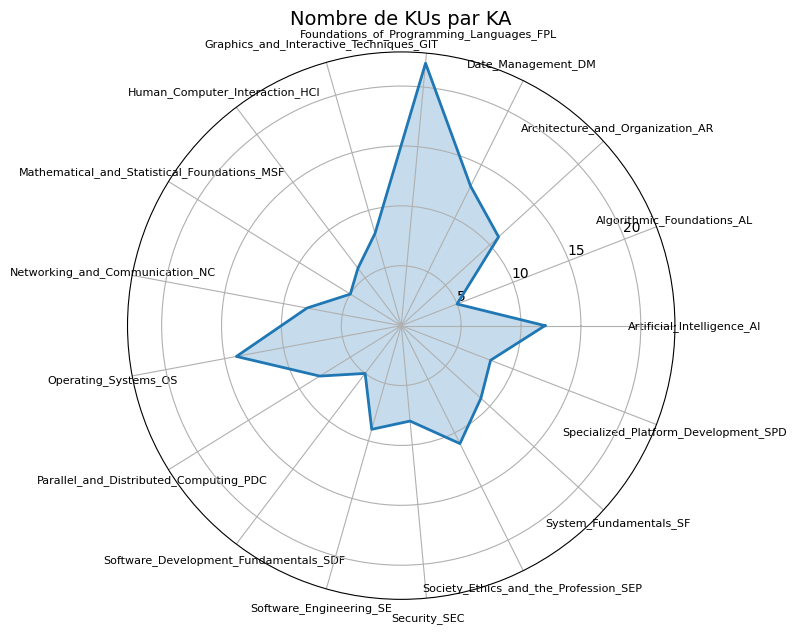

In [ ]:

# this graph (./XP/graph_bok_nohours.ttl) looks good

gbok_ref = Graph()
BOK_RDF_FILE_PATH = "./XP/graph_bok_nohours.ttl"
gbok_ref.parse(BOK_RDF_FILE_PATH, format="turtle")
print(f"BOK Graph loaded : {g.__len__()} triples")

query_du= """
PREFIX bok: <http://example.org/bok/> 
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#> 

SELECT  (count(distinct ?ku) as ?nb_ku)
WHERE {
  ?ku bok:part_of ?ka .
} 
"""
nb_ku = gbok_ref.query(query_du)
for row in nb_ku:
    print(f"Number of distinct KU: {row.nb_ku}")

distinct_ku= """
PREFIX bok: <http://example.org/bok/> 
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#> 

SELECT ?ka (count(distinct ?ku) as ?nb_ku)
WHERE {
  ?ku bok:part_of ?ka .
} group by ?ka
"""

qres_ref = gbok_ref.query(distinct_ku)
# Extraire les données
labels = []
values = []

for row in qres_ref:
    labels.append(str(row.ka).split("/")[-1])
    values.append(int(row.nb_ku))

# Fermer le polygone
values.append(values[0])  # refermer la boucle des valeurs
angles = np.linspace(0, 2 * np.pi, len(values) - 1, endpoint=False).tolist()
angles.append(angles[0])  # refermer la boucle des angles

# Radar plot
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
ax.plot(angles, values, linewidth=2)
ax.fill(angles, values, alpha=0.25)

# Axe des noms : attention, angles[:-1] car le dernier est la fermeture
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=8)
ax.set_title("Nombre de KUs par KA", size=14, pad=20)
ax.grid(True)
plt.tight_layout()
plt.show()
